In [ ]:
import os
import time
from basic_parameters import basic_params
from process import processing_and_save
timer = time.time()
os.system("mpiexec -n 6 python3 base_model.py")
print("Simulation is finished!")
print(time.time() - timer)

file = basic_params["file_results"]
processing_and_save(file)


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 2)
from basic_parameters import basic_params
import plot_result as my_plot

file = basic_params["file_results"]
# my_plot.plot_v(file)

# my_plot.plot_spike_raster(file)
my_plot.plot_lfp(file)
# my_plot.plot_phase_disrtibution(file)


In [ ]:
from process import processing_and_save
from basic_parameters import basic_params

file = basic_params["file_results"]
processing_and_save(file)



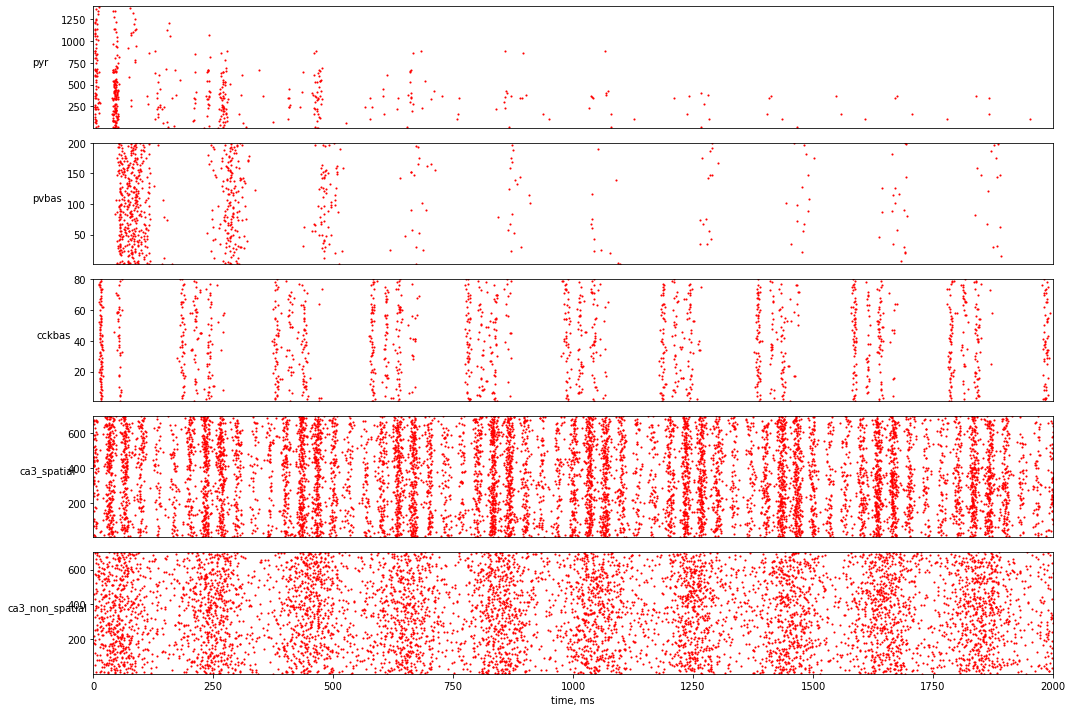

In [24]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt
from matplotlib import gridspec
import h5py
from basic_parameters import basic_params
import processingLib as proclib
plt.rcParams["figure.figsize"] = (15, 2)
from basic_parameters import basic_params
# import plot_result as my_plot
neuron_order = ["pyr", "pvbas", "cckbas", "ca3_spatial", "ca3_non_spatial"]
filepath = basic_params["file_results"]
# my_plot.plot_spike_raster(file)

with h5py.File(filepath, 'r') as h5file:
    t0 = h5file["time"][0]
    t1 = h5file["time"][-1]
    raster_group = h5file["extracellular/electrode_1/firing/origin_data"]
                
    fig = plt.figure(figsize=(15, 10))
        
    neurons_num = len(neuron_order)
    gs = gridspec.GridSpec(neurons_num, 1)

    for celltype_idx, celltype in enumerate(neuron_order):
        try:
            celltype_group = raster_group[celltype]
            axes = plt.subplot(gs[celltype_idx])
           
            for sp_idx, (cell_key, firing) in enumerate(celltype_group.items()):
                sp_idx += 1
                axes.scatter(firing,  np.zeros(firing.size) + sp_idx, s=1.2, color="red" )

            axes.set_ylim(1, sp_idx)
            axes.set_xlim(t0, t1)
            axes.set_ylabel(celltype, rotation='horizontal', labelpad=20)

            if celltype_idx == len(neuron_order) - 1:
                axes.set_xlabel("time, ms")
            else:
                axes.tick_params(labelbottom=False, bottom=False)
        except KeyError:
            continue
fig.tight_layout()
plt.show()